In [3]:
import pylife.mesh.gradient
import numpy as np
import pandas as pd

In [101]:
def create_mesh(n):
    x_list = np.linspace(0, 1, n)
    y_list = np.linspace(0, 1, n)
    z_list = np.linspace(0, 1, n)
    X,Y,Z = np.meshgrid(x_list, y_list, z_list)
    h = 1/n

    df_node_mesh = pd.DataFrame({"x": X.flatten(), "y": Y.flatten(), "z": Z.flatten()})

    df_node_mesh.x += (2*np.random.random(size=(n**3))-1)*h*0.4
    df_node_mesh.y += (2*np.random.random(size=(n**3))-1)*h*0.4
    df_node_mesh.z += (2*np.random.random(size=(n**3))-1)*h*0.4

    df_node_mesh["mises"] = np.random.random(size=(n**3))
    df_node_mesh.reset_index(names=["node_id"], inplace=True)

    # add elements
    df_list = []
    for k in range(n-1):
        for j in range(n-1):
            for i in range(n-1):
                element_id = k*(n-1)*(n-1) + j*(n-1) + i
                nodes = [
                    df_node_mesh.iloc[k*n*n + j*n + i,:],
                    df_node_mesh.iloc[k*n*n + j*n + i+1,:],
                    df_node_mesh.iloc[k*n*n + (j+1)*n + i+1,:],
                    df_node_mesh.iloc[k*n*n + (j+1)*n + i,:],
                    df_node_mesh.iloc[(k+1)*n*n + j*n + i,:],
                    df_node_mesh.iloc[(k+1)*n*n + j*n + i+1,:],
                    df_node_mesh.iloc[(k+1)*n*n + (j+1)*n + i+1,:],
                    df_node_mesh.iloc[(k+1)*n*n + (j+1)*n + i,:]
                ]
                df = pd.concat(nodes, axis=1).T
                df["element_id"] = element_id
                df_list.append(df)
    df_mesh = pd.concat(df_list)
    df_mesh.set_index(["element_id", "node_id"], inplace=True)
    df_mesh.index = df_mesh.index.set_levels(df_mesh.index.levels[0].astype(int), level=0)
    df_mesh.index = df_mesh.index.set_levels(df_mesh.index.levels[1].astype(int), level=1)
    
    return df_mesh


In [103]:
df_mesh = create_mesh(n=3)
df_mesh

x         y         z     mises
element_id node_id                                        
0          0        0.014653 -0.127146 -0.095331  0.967623
           1       -0.095923 -0.002115  0.424812  0.927187
           4        0.381581 -0.058375  0.467451  0.885155
           3        0.450068  0.074666  0.009492  0.969813
           9       -0.058876  0.453468 -0.084940  0.434767
...                      ...       ...       ...       ...
7          16       1.034133  0.517035  0.559801  0.649114
           22       0.509410  1.074111  0.631328  0.683837
           23       0.535318  1.105858  0.914099  0.347442
           26       0.892281  1.010772  0.986774  0.485307
           25       0.880664  1.093489  0.474950  0.743276

[64 rows x 4 columns]

In [104]:
import timeit

def evaluate(n):
    df_mesh = create_mesh(n)

    tstart = timeit.default_timer()
    # given a mesh in `pylife_mesh` with column `mises`, compute the gradient
    gradient2 = df_mesh.copy().gradient.gradient_of('mises')

    tm = timeit.default_timer()
    # given a mesh in `pylife_mesh` with column `mises`, compute the gradient
    gradient = df_mesh.gradient_3D.gradient_of('mises')
    
    tend = timeit.default_timer()

    return n**3, tm - tstart, tend-tm

In [105]:
df_mesh = create_mesh(4)
gradient = df_mesh.gradient_3D.gradient_of('mises')

In [108]:
measurements = pd.DataFrame([evaluate(n) for n in range(2,15)], columns=["number of nodes", "time gradient", "time gradient_3D"])
measurements

,number of nodes,time gradient,time gradient_3D
0,8,0.006999,0.008013
1,27,0.007274,0.023832
2,64,0.014600,0.076214
3,125,0.027407,0.177685
4,216,0.046525,0.346051
5,343,0.074140,0.595319
6,512,0.112052,1.012772
7,729,0.179701,1.410299
8,1000,0.233567,2.006580
9,1331,0.318788,2.828625


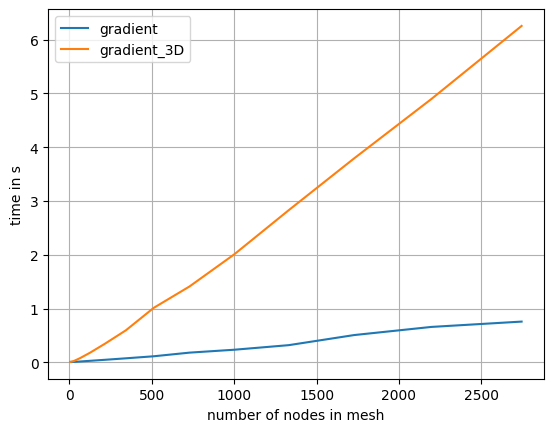

In [111]:
import matplotlib.pyplot as plt
plt.plot(measurements["number of nodes"], measurements["time gradient"], label="gradient")
plt.plot(measurements["number of nodes"], measurements["time gradient_3D"], label="gradient_3D")
plt.xlabel("number of nodes in mesh")
plt.ylabel("time in s")
plt.grid(which="both")
plt.legend()

In [68]:
df_mesh_with_gradient2

x         y         z     mises  dmises_dx  \
element_id node_id                                                      
0          0        0.092353 -0.004481  0.059205  0.366320  -0.265263   
           1        0.024608  0.081111  0.580522  0.268546   0.310299   
           4        0.489979  0.086659  0.512854  0.612951  -0.048427   
           3        0.562759 -0.101215  0.055262  0.104495   0.029081   
           3        0.562759 -0.101215  0.055262  0.104495   0.029081   
...                      ...       ...       ...       ...        ...   
5          10       0.096265  0.506826  0.623815  0.893474  -0.249966   
           10       0.096265  0.506826  0.623815  0.893474  -0.249966   
           11       0.049609  0.484082  0.958726  0.579378  -0.108618   
           14       0.513371  0.531902  0.998462  0.955951  -0.298339   
           13       0.494419  0.471937  0.426106  0.574260  -0.397669   

                    dmises_dy  dmises_dz  
element_id node_id                        
0          0        -0.818071   0.163041  
           1         0.608780   0.370413  
           4         0.847737   0.022199  
           3         1.558489   0.017319  
           3         1.558489   0.017319  
...                       ...        ...  
5          10        0.658794   0.054370  
           10        0.658794   0.054370  
           11        0.732070  -0.274674  
           14        0.601045   0.141921  
           13        0.087835  -0.137823  

[64 rows x 7 columns]